In [1]:
# =============================================================================
# NOTEBOOK 04: CUSTOMER SEGMENTATION
# =============================================================================
# Project: Retail Predictive Analytics Suite
# Author: [Your Name]
# Date: 2024
# Objective: Segment customers using RFM analysis and K-Means clustering
# =============================================================================

# =============================================================================
# CELL 1: IMPORT LIBRARIES
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Model Persistence
import joblib

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Libraries imported successfully
Analysis Date: 2026-02-11 13:21


In [2]:
# =============================================================================
# CELL 2: LOAD DATA
# =============================================================================

# Load cleaned dataset
df = pd.read_csv('../data/processed/clean_retail.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("=" * 60)
print("DATA LOADED")
print("=" * 60)
print(f"Total Records: {len(df):,}")
print(f"Unique Customers: {df['Customer ID'].nunique():,}")
print(f"Date Range: {df['InvoiceDate'].min().date()} to {df['InvoiceDate'].max().date()}")

# Display sample
print("\nSample Data:")
display(df.head())

DATA LOADED
Total Records: 779,425
Unique Customers: 5,878
Date Range: 2009-12-01 to 2011-12-09

Sample Data:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue,Year,Month,Day,DayOfWeek,Hour,YearMonth,DayName
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.40,2009,12,1,1,7,2009-12,Tuesday
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00,2009,12,1,1,7,2009-12,Tuesday
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00,2009,12,1,1,7,2009-12,Tuesday
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.80,2009,12,1,1,7,2009-12,Tuesday
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.00,2009,12,1,1,7,2009-12,Tuesday


In [3]:
# =============================================================================
# CELL 3: DEFINE REFERENCE DATE
# =============================================================================

print("=" * 60)
print("REFERENCE DATE FOR RFM CALCULATION")
print("=" * 60)

# Reference date = day after last transaction
reference_date = df['InvoiceDate'].max() + timedelta(days=1)

print(f"Last Transaction Date: {df['InvoiceDate'].max().date()}")
print(f"Reference Date: {reference_date.date()}")
print("\nThis date will be used to calculate Recency (days since last purchase)")

REFERENCE DATE FOR RFM CALCULATION
Last Transaction Date: 2011-12-09
Reference Date: 2011-12-10

This date will be used to calculate Recency (days since last purchase)


In [4]:
# =============================================================================
# CELL 4: CALCULATE RFM METRICS
# =============================================================================

print("=" * 60)
print("RFM METRICS CALCULATION")
print("=" * 60)

# Calculate RFM for each customer
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                       # Frequency
    'Revenue': 'sum'                                            # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("RFM Metrics Explained:")
print("-" * 60)
print("Recency (R):   Days since last purchase (lower = better)")
print("Frequency (F): Number of purchases (higher = better)")
print("Monetary (M):  Total amount spent (higher = better)")

print(f"\nTotal Customers: {len(rfm):,}")
print("\nRFM Sample Data:")
display(rfm.head(10))

RFM METRICS CALCULATION
RFM Metrics Explained:
------------------------------------------------------------
Recency (R):   Days since last purchase (lower = better)
Frequency (F): Number of purchases (higher = better)
Monetary (M):  Total amount spent (higher = better)

Total Customers: 5,878

RFM Sample Data:


,CustomerID,Recency,Frequency,Monetary
0,12346,326,12,77556.46
1,12347,2,8,4921.53
2,12348,75,5,2019.40
3,12349,19,4,4428.69
4,12350,310,1,334.40
5,12351,375,1,300.93
6,12352,36,10,2849.84
7,12353,204,2,406.76
8,12354,232,1,1079.40
9,12355,214,2,947.61


In [5]:
# =============================================================================
# CELL 5: RFM STATISTICS
# =============================================================================

print("=" * 60)
print("RFM STATISTICS")
print("=" * 60)

# Descriptive statistics
print("\nDescriptive Statistics:")
display(rfm[['Recency', 'Frequency', 'Monetary']].describe())

# Additional statistics
print("\nAdditional Insights:")
print("-" * 60)
print(f"Average Recency: {rfm['Recency'].mean():.1f} days")
print(f"Median Recency: {rfm['Recency'].median():.1f} days")
print(f"Average Frequency: {rfm['Frequency'].mean():.2f} orders")
print(f"Median Frequency: {rfm['Frequency'].median():.0f} orders")
print(f"Average Monetary: {rfm['Monetary'].mean():,.2f} GBP")
print(f"Median Monetary: {rfm['Monetary'].median():,.2f} GBP")

RFM STATISTICS

Descriptive Statistics:


,Recency,Frequency,Monetary
count,5878.00,5878.00,5878.00
mean,201.33,6.29,2955.90
std,209.34,13.01,14440.85
min,1.00,1.00,2.95
25%,26.00,1.00,342.28
50%,96.00,3.00,867.74
75%,380.00,7.00,2248.30
max,739.00,398.00,580987.04



Additional Insights:
------------------------------------------------------------
Average Recency: 201.3 days
Median Recency: 96.0 days
Average Frequency: 6.29 orders
Median Frequency: 3 orders
Average Monetary: 2,955.90 GBP
Median Monetary: 867.74 GBP


RFM DISTRIBUTION ANALYSIS


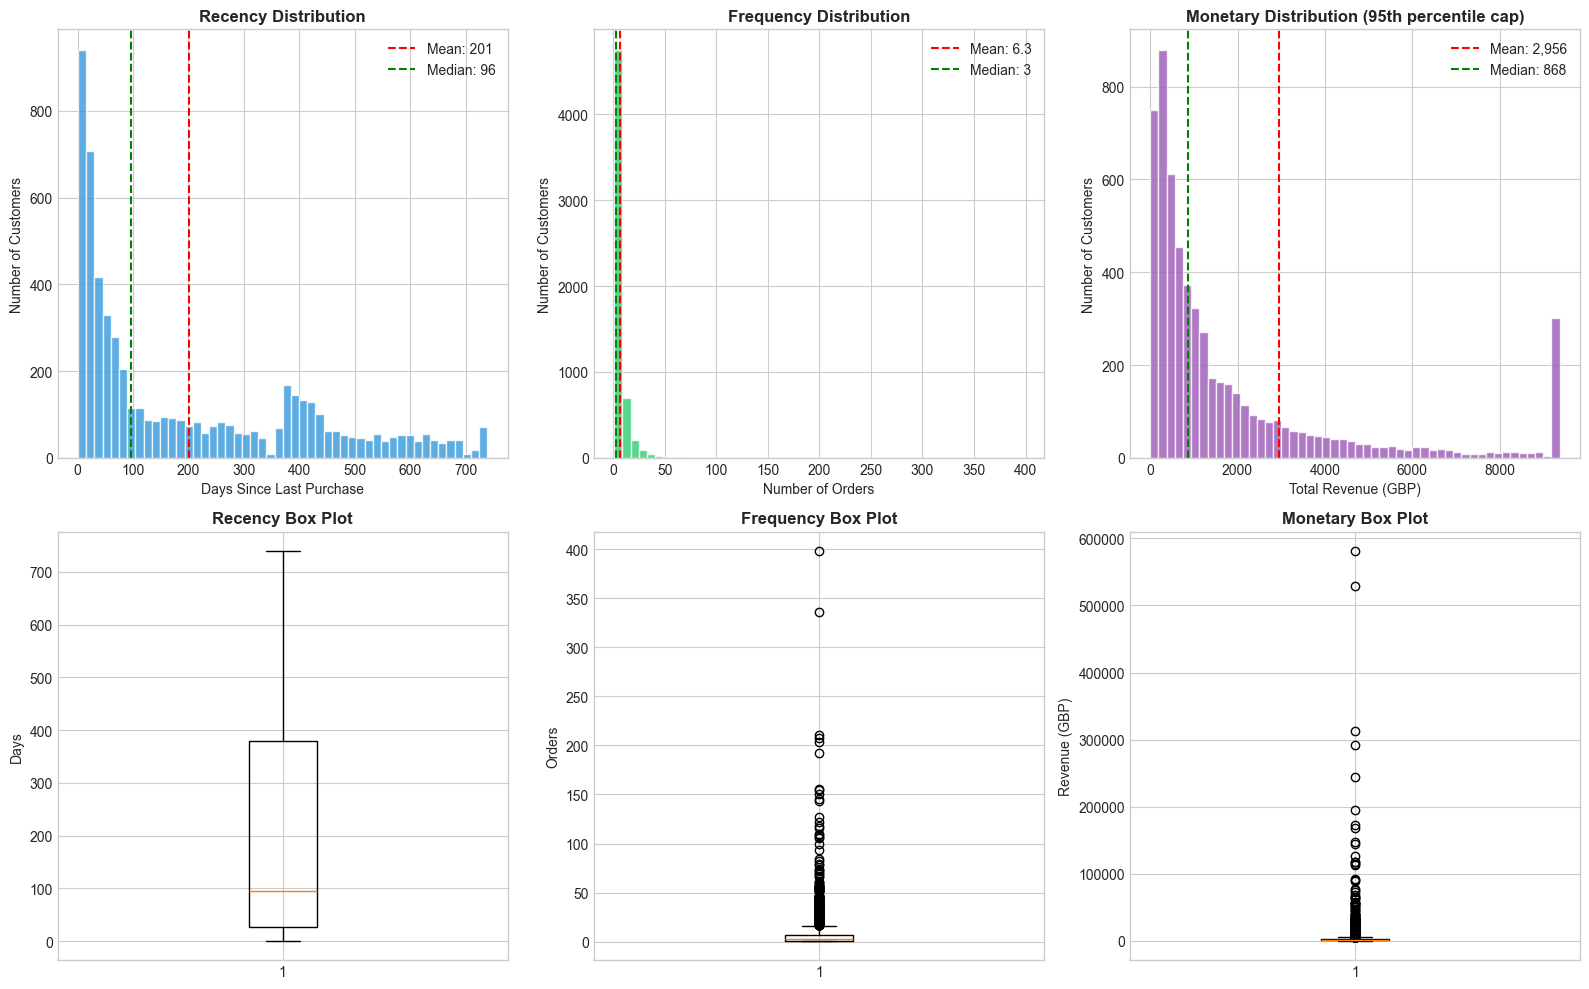


Plot saved: outputs/segmentation/rfm_distributions.png


In [6]:
# =============================================================================
# CELL 6: RFM DISTRIBUTION VISUALIZATION
# =============================================================================

print("=" * 60)
print("RFM DISTRIBUTION ANALYSIS")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Row 1: Histograms
ax1 = axes[0, 0]
ax1.hist(rfm['Recency'], bins=50, color='#3498db', edgecolor='white', alpha=0.8)
ax1.axvline(rfm['Recency'].mean(), color='red', linestyle='--', label=f'Mean: {rfm["Recency"].mean():.0f}')
ax1.axvline(rfm['Recency'].median(), color='green', linestyle='--', label=f'Median: {rfm["Recency"].median():.0f}')
ax1.set_title('Recency Distribution', fontsize=12, fontweight='bold')
ax1.set_xlabel('Days Since Last Purchase')
ax1.set_ylabel('Number of Customers')
ax1.legend()

ax2 = axes[0, 1]
ax2.hist(rfm['Frequency'], bins=50, color='#2ecc71', edgecolor='white', alpha=0.8)
ax2.axvline(rfm['Frequency'].mean(), color='red', linestyle='--', label=f'Mean: {rfm["Frequency"].mean():.1f}')
ax2.axvline(rfm['Frequency'].median(), color='green', linestyle='--', label=f'Median: {rfm["Frequency"].median():.0f}')
ax2.set_title('Frequency Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Number of Orders')
ax2.set_ylabel('Number of Customers')
ax2.legend()

ax3 = axes[0, 2]
ax3.hist(rfm['Monetary'].clip(upper=rfm['Monetary'].quantile(0.95)), 
         bins=50, color='#9b59b6', edgecolor='white', alpha=0.8)
ax3.axvline(rfm['Monetary'].mean(), color='red', linestyle='--', label=f'Mean: {rfm["Monetary"].mean():,.0f}')
ax3.axvline(rfm['Monetary'].median(), color='green', linestyle='--', label=f'Median: {rfm["Monetary"].median():,.0f}')
ax3.set_title('Monetary Distribution (95th percentile cap)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Total Revenue (GBP)')
ax3.set_ylabel('Number of Customers')
ax3.legend()

# Row 2: Box plots
ax4 = axes[1, 0]
ax4.boxplot(rfm['Recency'], vert=True)
ax4.set_title('Recency Box Plot', fontsize=12, fontweight='bold')
ax4.set_ylabel('Days')

ax5 = axes[1, 1]
ax5.boxplot(rfm['Frequency'], vert=True)
ax5.set_title('Frequency Box Plot', fontsize=12, fontweight='bold')
ax5.set_ylabel('Orders')

ax6 = axes[1, 2]
ax6.boxplot(rfm['Monetary'], vert=True)
ax6.set_title('Monetary Box Plot', fontsize=12, fontweight='bold')
ax6.set_ylabel('Revenue (GBP)')

plt.tight_layout()
plt.savefig('../outputs/segmentation/rfm_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/segmentation/rfm_distributions.png")

HANDLING OUTLIERS AND SKEWNESS
Skewness Before Transformation:
----------------------------------------
Recency: 0.8872
Frequency: 12.6400
Monetary: 25.0702

Skewness After Log Transformation:
----------------------------------------
Recency_Log: -0.4886
Frequency_Log: 1.0015
Monetary_Log: 0.2691


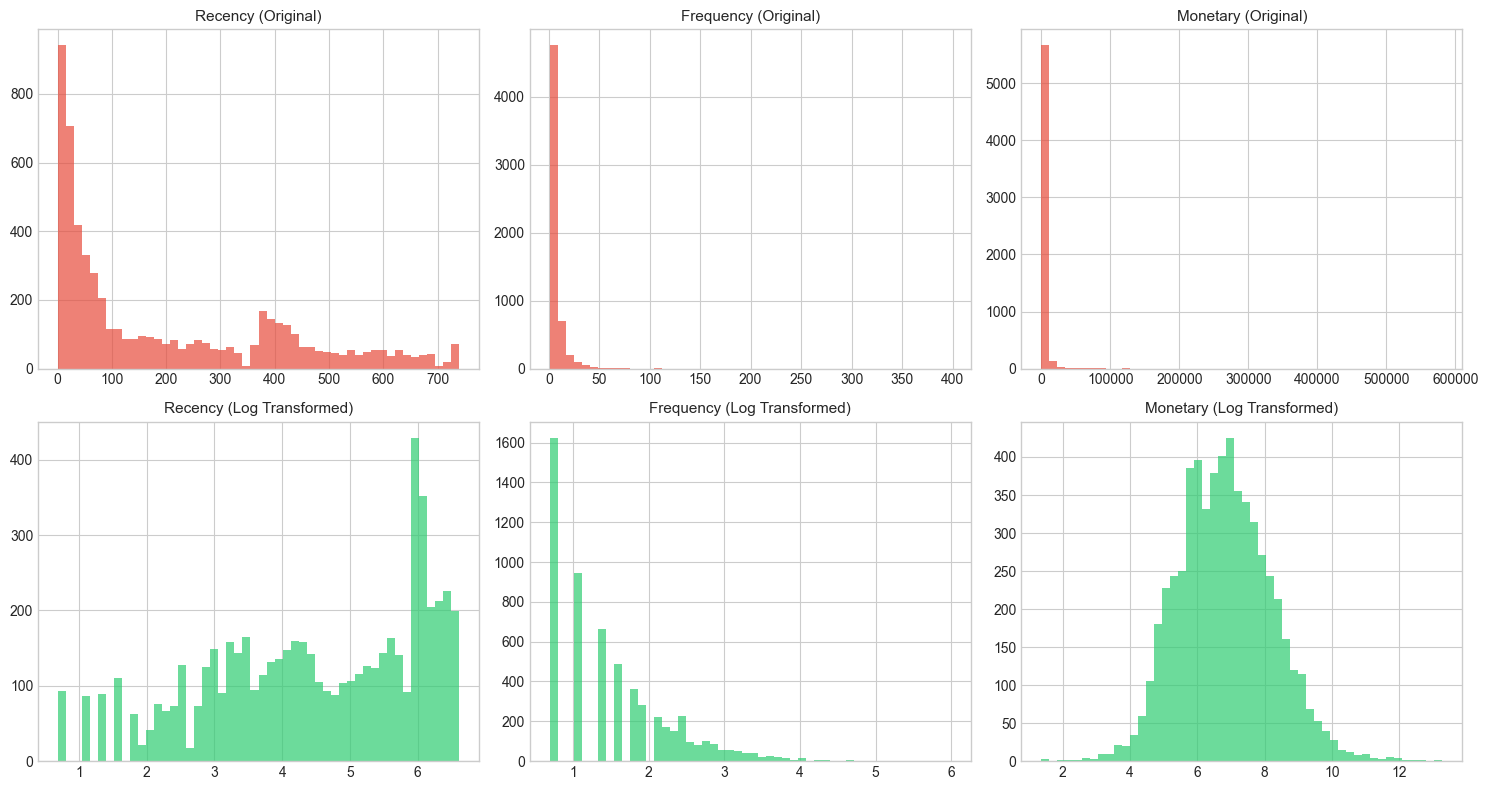


Plot saved: outputs/segmentation/log_transformation.png


In [7]:
# =============================================================================
# CELL 7: HANDLE OUTLIERS AND SKEWNESS
# =============================================================================

print("=" * 60)
print("HANDLING OUTLIERS AND SKEWNESS")
print("=" * 60)

# Check skewness before transformation
print("Skewness Before Transformation:")
print("-" * 40)
for col in ['Recency', 'Frequency', 'Monetary']:
    skew = rfm[col].skew()
    print(f"{col}: {skew:.4f}")

# Apply log transformation to handle skewness
rfm_log = rfm.copy()
rfm_log['Recency_Log'] = np.log1p(rfm_log['Recency'])
rfm_log['Frequency_Log'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary_Log'] = np.log1p(rfm_log['Monetary'])

print("\nSkewness After Log Transformation:")
print("-" * 40)
for col in ['Recency_Log', 'Frequency_Log', 'Monetary_Log']:
    skew = rfm_log[col].skew()
    print(f"{col}: {skew:.4f}")

# Visualize transformation effect
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Before transformation
axes[0, 0].hist(rfm['Recency'], bins=50, color='#e74c3c', alpha=0.7)
axes[0, 0].set_title('Recency (Original)', fontsize=11)

axes[0, 1].hist(rfm['Frequency'], bins=50, color='#e74c3c', alpha=0.7)
axes[0, 1].set_title('Frequency (Original)', fontsize=11)

axes[0, 2].hist(rfm['Monetary'], bins=50, color='#e74c3c', alpha=0.7)
axes[0, 2].set_title('Monetary (Original)', fontsize=11)

# After transformation
axes[1, 0].hist(rfm_log['Recency_Log'], bins=50, color='#2ecc71', alpha=0.7)
axes[1, 0].set_title('Recency (Log Transformed)', fontsize=11)

axes[1, 1].hist(rfm_log['Frequency_Log'], bins=50, color='#2ecc71', alpha=0.7)
axes[1, 1].set_title('Frequency (Log Transformed)', fontsize=11)

axes[1, 2].hist(rfm_log['Monetary_Log'], bins=50, color='#2ecc71', alpha=0.7)
axes[1, 2].set_title('Monetary (Log Transformed)', fontsize=11)

plt.tight_layout()
plt.savefig('../outputs/segmentation/log_transformation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/segmentation/log_transformation.png")

In [8]:
# =============================================================================
# CELL 8: STANDARDIZE FEATURES
# =============================================================================

print("=" * 60)
print("FEATURE STANDARDIZATION")
print("=" * 60)

# Select features for clustering
features = ['Recency_Log', 'Frequency_Log', 'Monetary_Log']
X = rfm_log[features].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create dataframe with scaled features
rfm_scaled = pd.DataFrame(X_scaled, columns=['Recency_Scaled', 'Frequency_Scaled', 'Monetary_Scaled'])

print("Standardization Applied (Mean=0, Std=1)")
print("\nScaled Features Statistics:")
display(rfm_scaled.describe())

# Save scaler
joblib.dump(scaler, '../models/scaler.pkl')
print("\nScaler saved: models/scaler.pkl")

FEATURE STANDARDIZATION
Standardization Applied (Mean=0, Std=1)

Scaled Features Statistics:


,Recency_Scaled,Frequency_Scaled,Monetary_Scaled
count,5878.00,5878.00,5878.00
mean,-0.00,0.00,0.00
std,1.00,1.00,1.00
min,-2.41,-1.06,-3.93
25%,-0.74,-1.06,-0.71
50%,0.08,-0.20,-0.04
75%,0.95,0.65,0.65
max,1.38,5.48,4.66



Scaler saved: models/scaler.pkl


In [9]:
# =============================================================================
# CELL 9: FIND OPTIMAL NUMBER OF CLUSTERS - ELBOW METHOD
# =============================================================================

print("=" * 60)
print("OPTIMAL CLUSTERS - ELBOW METHOD")
print("=" * 60)

# Calculate WCSS for different number of clusters
k_range = range(2, 11)
wcss = []
silhouette_scores = []
calinski_scores = []
davies_scores = []

print("Evaluating K values...")
print("-" * 60)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(X_scaled)
    
    wcss.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, kmeans.labels_)
    cal_score = calinski_harabasz_score(X_scaled, kmeans.labels_)
    dav_score = davies_bouldin_score(X_scaled, kmeans.labels_)
    
    silhouette_scores.append(sil_score)
    calinski_scores.append(cal_score)
    davies_scores.append(dav_score)
    
    print(f"K={k}: WCSS={kmeans.inertia_:.2f}, Silhouette={sil_score:.4f}, Calinski={cal_score:.2f}, Davies={dav_score:.4f}")

# Create evaluation dataframe
cluster_eval = pd.DataFrame({
    'K': list(k_range),
    'WCSS': wcss,
    'Silhouette': silhouette_scores,
    'Calinski_Harabasz': calinski_scores,
    'Davies_Bouldin': davies_scores
})

print("\nCluster Evaluation Summary:")
display(cluster_eval)

OPTIMAL CLUSTERS - ELBOW METHOD
Evaluating K values...
------------------------------------------------------------
K=2: WCSS=8588.99, Silhouette=0.4386, Calinski=6187.99, Davies=0.8727
K=3: WCSS=6354.34, Silhouette=0.3477, Calinski=5214.62, Davies=1.0361
K=4: WCSS=4921.23, Silhouette=0.3650, Calinski=5058.07, Davies=0.9299
K=5: WCSS=4099.11, Silhouette=0.3425, Calinski=4848.23, Davies=0.9497
K=6: WCSS=3554.70, Silhouette=0.3348, Calinski=4651.57, Davies=0.9639
K=7: WCSS=3194.50, Silhouette=0.3066, Calinski=4422.95, Davies=0.9805
K=8: WCSS=2902.43, Silhouette=0.3033, Calinski=4256.43, Davies=0.9863
K=9: WCSS=2656.56, Silhouette=0.2925, Calinski=4136.22, Davies=0.9996
K=10: WCSS=2467.38, Silhouette=0.2905, Calinski=4007.79, Davies=1.0021

Cluster Evaluation Summary:


,K,WCSS,Silhouette,Calinski_Harabasz,Davies_Bouldin
0,2,8588.99,0.44,6187.99,0.87
1,3,6354.34,0.35,5214.62,1.04
2,4,4921.23,0.36,5058.07,0.93
3,5,4099.11,0.34,4848.23,0.95
4,6,3554.70,0.33,4651.57,0.96
5,7,3194.50,0.31,4422.95,0.98
6,8,2902.43,0.30,4256.43,0.99
7,9,2656.56,0.29,4136.22,1.00
8,10,2467.38,0.29,4007.79,1.00


CLUSTER EVALUATION VISUALIZATION


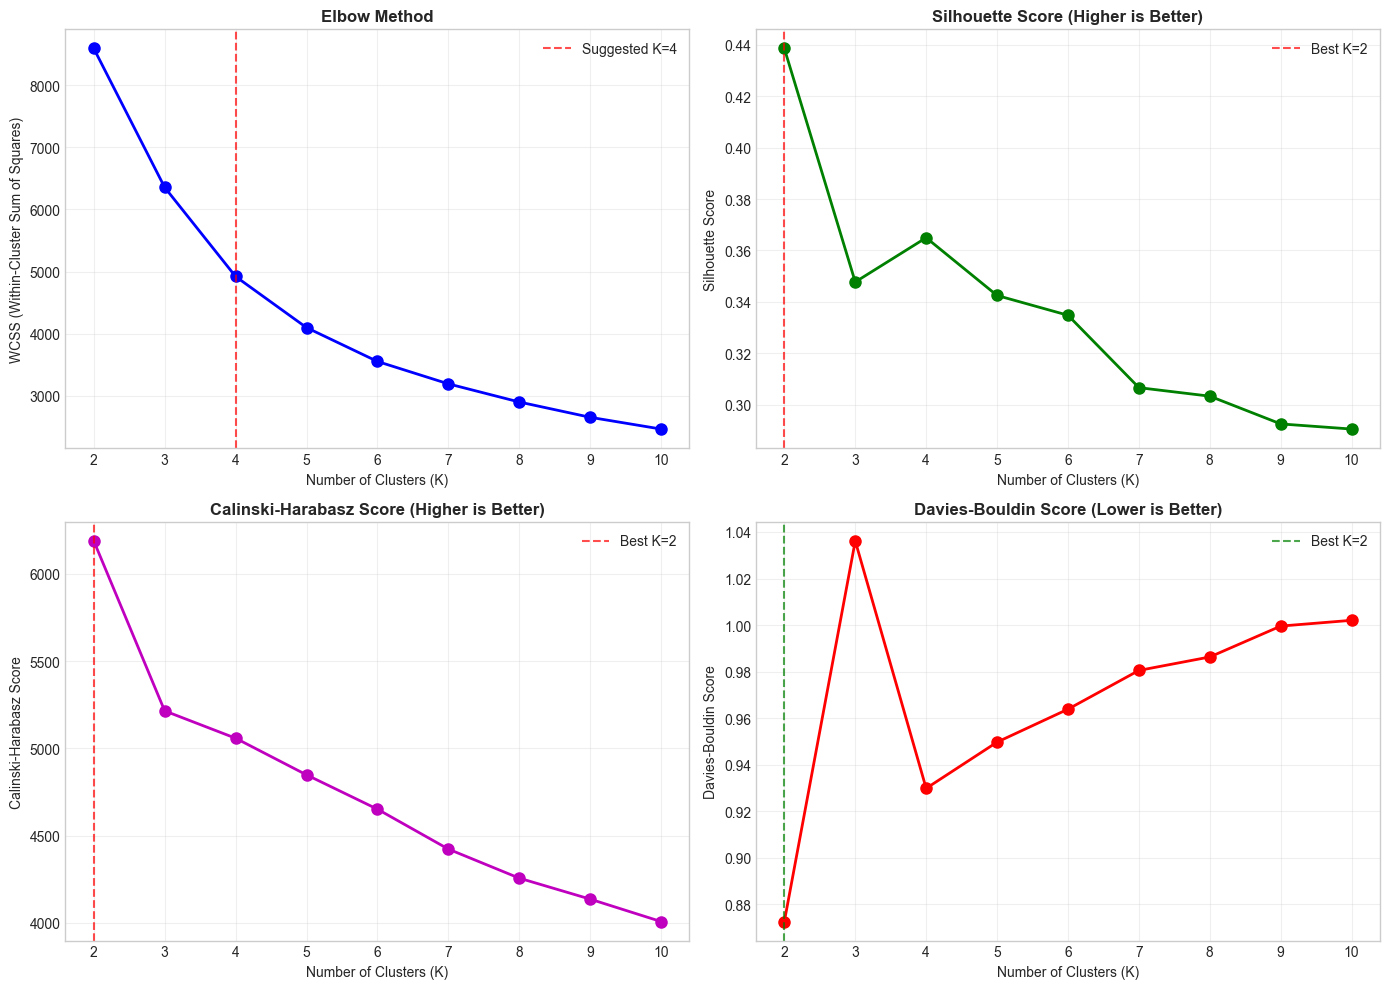


Plot saved: outputs/segmentation/cluster_evaluation.png

Optimal K Recommendations:
----------------------------------------
Silhouette Score: K = 2
Calinski-Harabasz: K = 2
Davies-Bouldin: K = 2


In [10]:
# =============================================================================
# CELL 10: VISUALIZE CLUSTER EVALUATION METRICS
# =============================================================================

print("=" * 60)
print("CLUSTER EVALUATION VISUALIZATION")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Elbow Method (WCSS)
ax1 = axes[0, 0]
ax1.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('WCSS (Within-Cluster Sum of Squares)')
ax1.set_title('Elbow Method', fontsize=12, fontweight='bold')
ax1.axvline(x=4, color='red', linestyle='--', alpha=0.7, label='Suggested K=4')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Silhouette Score
ax2 = axes[0, 1]
ax2.plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score (Higher is Better)', fontsize=12, fontweight='bold')
best_k_sil = k_range[np.argmax(silhouette_scores)]
ax2.axvline(x=best_k_sil, color='red', linestyle='--', alpha=0.7, label=f'Best K={best_k_sil}')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Calinski-Harabasz Score
ax3 = axes[1, 0]
ax3.plot(k_range, calinski_scores, 'mo-', linewidth=2, markersize=8)
ax3.set_xlabel('Number of Clusters (K)')
ax3.set_ylabel('Calinski-Harabasz Score')
ax3.set_title('Calinski-Harabasz Score (Higher is Better)', fontsize=12, fontweight='bold')
best_k_cal = k_range[np.argmax(calinski_scores)]
ax3.axvline(x=best_k_cal, color='red', linestyle='--', alpha=0.7, label=f'Best K={best_k_cal}')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Davies-Bouldin Score
ax4 = axes[1, 1]
ax4.plot(k_range, davies_scores, 'ro-', linewidth=2, markersize=8)
ax4.set_xlabel('Number of Clusters (K)')
ax4.set_ylabel('Davies-Bouldin Score')
ax4.set_title('Davies-Bouldin Score (Lower is Better)', fontsize=12, fontweight='bold')
best_k_dav = k_range[np.argmin(davies_scores)]
ax4.axvline(x=best_k_dav, color='green', linestyle='--', alpha=0.7, label=f'Best K={best_k_dav}')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/segmentation/cluster_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/segmentation/cluster_evaluation.png")

# Determine optimal K
print("\nOptimal K Recommendations:")
print("-" * 40)
print(f"Silhouette Score: K = {best_k_sil}")
print(f"Calinski-Harabasz: K = {best_k_cal}")
print(f"Davies-Bouldin: K = {best_k_dav}")

In [11]:
# =============================================================================
# CELL 11: TRAIN FINAL K-MEANS MODEL
# =============================================================================

print("=" * 60)
print("TRAINING FINAL K-MEANS MODEL")
print("=" * 60)

# Choose optimal K (typically 4 for RFM segmentation)
optimal_k = 4

print(f"Selected Number of Clusters: {optimal_k}")
print("\nTraining K-Means model...")

# Train final model
kmeans_final = KMeans(
    n_clusters=optimal_k,
    random_state=42,
    n_init=10,
    max_iter=300
)

kmeans_final.fit(X_scaled)

# Get cluster labels
cluster_labels = kmeans_final.labels_

# Add clusters to RFM dataframe
rfm['Cluster'] = cluster_labels
rfm_log['Cluster'] = cluster_labels

print(f"\nModel trained successfully")
print(f"Inertia (WCSS): {kmeans_final.inertia_:.2f}")
print(f"Silhouette Score: {silhouette_score(X_scaled, cluster_labels):.4f}")

# Cluster distribution
print("\nCluster Distribution:")
print("-" * 40)
cluster_counts = rfm['Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    pct = count / len(rfm) * 100
    print(f"Cluster {cluster}: {count:,} customers ({pct:.1f}%)")

# Save model
joblib.dump(kmeans_final, '../models/kmeans_model.pkl')
print("\nModel saved: models/kmeans_model.pkl")

TRAINING FINAL K-MEANS MODEL
Selected Number of Clusters: 4

Training K-Means model...

Model trained successfully
Inertia (WCSS): 4921.23
Silhouette Score: 0.3650

Cluster Distribution:
----------------------------------------
Cluster 0: 1,973 customers (33.6%)
Cluster 1: 1,250 customers (21.3%)
Cluster 2: 1,196 customers (20.3%)
Cluster 3: 1,459 customers (24.8%)

Model saved: models/kmeans_model.pkl


In [12]:
# =============================================================================
# CELL 12: ANALYZE CLUSTER CHARACTERISTICS
# =============================================================================

print("=" * 60)
print("CLUSTER CHARACTERISTICS ANALYSIS")
print("=" * 60)

# Calculate cluster statistics
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'min', 'max'],
    'Frequency': ['mean', 'median', 'min', 'max'],
    'Monetary': ['mean', 'median', 'min', 'max', 'sum'],
    'CustomerID': 'count'
}).round(2)

cluster_summary.columns = ['_'.join(col) for col in cluster_summary.columns]
cluster_summary = cluster_summary.rename(columns={'CustomerID_count': 'Customer_Count'})

print("\nCluster Summary Statistics:")
display(cluster_summary)

# Calculate cluster means for profiling
cluster_means = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
cluster_means['Customer_Count'] = rfm.groupby('Cluster')['CustomerID'].count()
cluster_means['Total_Revenue'] = rfm.groupby('Cluster')['Monetary'].sum()
cluster_means['Avg_Order_Value'] = cluster_means['Monetary'] / cluster_means['Frequency']

print("\nCluster Means:")
display(cluster_means)

CLUSTER CHARACTERISTICS ANALYSIS

Cluster Summary Statistics:


,Recency_mean,Recency_median,Recency_min,Recency_max,Frequency_mean,Frequency_median,Frequency_min,Frequency_max,Monetary_mean,Monetary_median,Monetary_min,Monetary_max,Monetary_sum,Customer_Count
Cluster,,,,,,,,,,,,,,
0,394.95,402.00,23,739,1.38,1.00,1,8,317.08,273.31,2.95,1651.72,625601.80,1973
1,28.30,24.00,1,99,3.05,3.00,1,14,857.49,734.12,43.20,4642.45,1071864.29,1250
2,27.71,17.00,1,576,19.28,13.00,2,398,10731.16,4986.12,862.42,580987.04,12834470.94,1196
3,230.07,186.00,31,738,5.06,4.00,1,20,1948.50,1450.04,167.42,44534.30,2842867.24,1459



Cluster Means:


,Recency,Frequency,Monetary,Customer_Count,Total_Revenue,Avg_Order_Value
Cluster,,,,,,
0,394.95,1.38,317.08,1973,625601.80,230.17
1,28.30,3.05,857.49,1250,1071864.29,280.81
2,27.71,19.28,10731.16,1196,12834470.94,556.71
3,230.07,5.06,1948.50,1459,2842867.24,385.21


In [13]:
# =============================================================================
# CELL 13: ASSIGN SEGMENT NAMES
# =============================================================================

print("=" * 60)
print("SEGMENT NAMING AND PROFILING")
print("=" * 60)

# Analyze each cluster to assign names
# Sort clusters by Monetary value to assign meaningful names
cluster_profile = cluster_means.copy()
cluster_profile['R_Rank'] = cluster_profile['Recency'].rank()
cluster_profile['F_Rank'] = cluster_profile['Frequency'].rank(ascending=False)
cluster_profile['M_Rank'] = cluster_profile['Monetary'].rank(ascending=False)

print("Cluster Ranking (R: lower=better, F/M: higher=better):")
display(cluster_profile[['Recency', 'Frequency', 'Monetary', 'R_Rank', 'F_Rank', 'M_Rank']])

# Create segment names based on RFM characteristics
def assign_segment_name(row):
    """
    Assign segment name based on RFM characteristics
    """
    recency = row['Recency']
    frequency = row['Frequency']
    monetary = row['Monetary']
    
    # Get overall means
    r_mean = rfm['Recency'].mean()
    f_mean = rfm['Frequency'].mean()
    m_mean = rfm['Monetary'].mean()
    
    # High value: Low R, High F, High M
    if recency < r_mean and frequency > f_mean and monetary > m_mean:
        return 'Champions'
    # Loyal: Medium R, High F
    elif frequency > f_mean * 1.5:
        return 'Loyal Customers'
    # At Risk: High R, High F/M historically
    elif recency > r_mean * 1.5 and (frequency > f_mean or monetary > m_mean):
        return 'At Risk'
    # New/Potential: Low R, Low F
    elif recency < r_mean and frequency < f_mean:
        return 'New Customers'
    # Hibernating: High R, Low F, Low M
    else:
        return 'Hibernating'

# Apply segment names
segment_names = {}
for cluster in cluster_means.index:
    row = cluster_means.loc[cluster]
    segment_names[cluster] = assign_segment_name(row)

print("\nAssigned Segment Names:")
print("-" * 40)
for cluster, name in segment_names.items():
    print(f"Cluster {cluster}: {name}")

# Add segment names to dataframe
rfm['Segment'] = rfm['Cluster'].map(segment_names)

print("\nSegment Distribution:")
display(rfm['Segment'].value_counts())

SEGMENT NAMING AND PROFILING
Cluster Ranking (R: lower=better, F/M: higher=better):


,Recency,Frequency,Monetary,R_Rank,F_Rank,M_Rank
Cluster,,,,,,
0,394.95,1.38,317.08,4.00,4.00,4.00
1,28.30,3.05,857.49,2.00,3.00,3.00
2,27.71,19.28,10731.16,1.00,1.00,1.00
3,230.07,5.06,1948.50,3.00,2.00,2.00



Assigned Segment Names:
----------------------------------------
Cluster 0: Hibernating
Cluster 1: New Customers
Cluster 2: Champions
Cluster 3: Hibernating

Segment Distribution:


Segment
Hibernating      3432
New Customers    1250
Champions        1196
Name: count, dtype: int64

SEGMENT VISUALIZATION


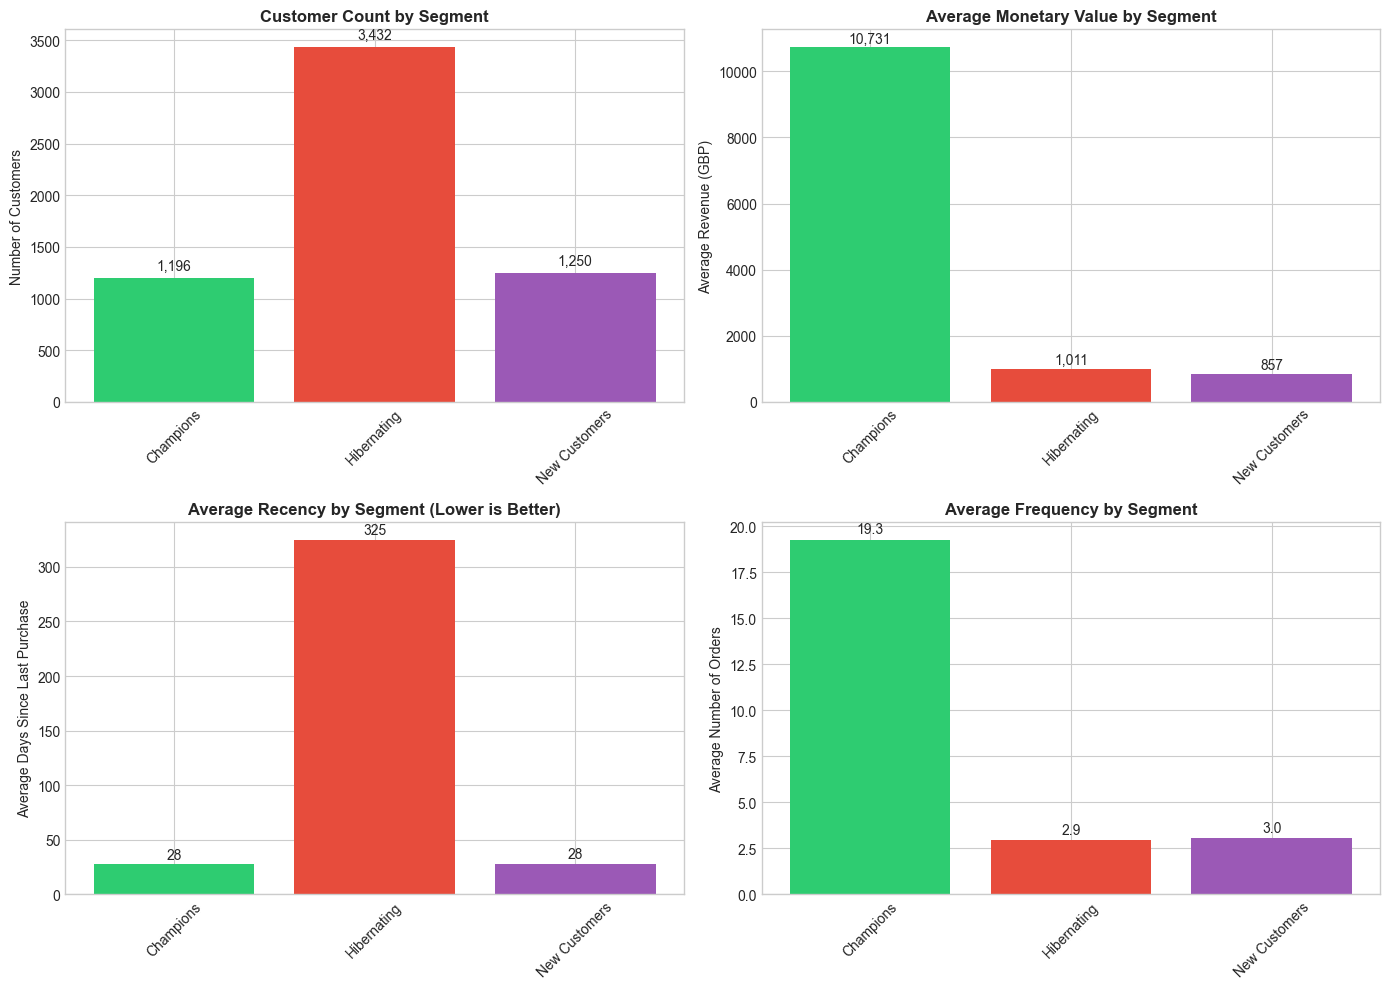


Plot saved: outputs/segmentation/segment_bar_charts.png


In [14]:
# =============================================================================
# CELL 14: SEGMENT VISUALIZATION - BAR CHARTS
# =============================================================================

print("=" * 60)
print("SEGMENT VISUALIZATION")
print("=" * 60)

# Prepare data for visualization
segment_summary = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(2)

segment_summary.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Customer_Count']
segment_summary = segment_summary.sort_values('Avg_Monetary', ascending=False)

# Define colors for segments
colors = {
    'Champions': '#2ecc71',
    'Loyal Customers': '#3498db',
    'New Customers': '#9b59b6',
    'At Risk': '#f39c12',
    'Hibernating': '#e74c3c'
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Customer Count by Segment
ax1 = axes[0, 0]
segment_colors = [colors.get(seg, '#95a5a6') for seg in segment_summary.index]
bars1 = ax1.bar(segment_summary.index, segment_summary['Customer_Count'], color=segment_colors)
ax1.set_title('Customer Count by Segment', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Customers')
ax1.tick_params(axis='x', rotation=45)
for bar, val in zip(bars1, segment_summary['Customer_Count']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{val:,}', ha='center', va='bottom', fontsize=10)

# Plot 2: Average Monetary by Segment
ax2 = axes[0, 1]
bars2 = ax2.bar(segment_summary.index, segment_summary['Avg_Monetary'], color=segment_colors)
ax2.set_title('Average Monetary Value by Segment', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Revenue (GBP)')
ax2.tick_params(axis='x', rotation=45)
for bar, val in zip(bars2, segment_summary['Avg_Monetary']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{val:,.0f}', ha='center', va='bottom', fontsize=10)

# Plot 3: Average Recency by Segment
ax3 = axes[1, 0]
bars3 = ax3.bar(segment_summary.index, segment_summary['Avg_Recency'], color=segment_colors)
ax3.set_title('Average Recency by Segment (Lower is Better)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Average Days Since Last Purchase')
ax3.tick_params(axis='x', rotation=45)
for bar, val in zip(bars3, segment_summary['Avg_Recency']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{val:.0f}', ha='center', va='bottom', fontsize=10)

# Plot 4: Average Frequency by Segment
ax4 = axes[1, 1]
bars4 = ax4.bar(segment_summary.index, segment_summary['Avg_Frequency'], color=segment_colors)
ax4.set_title('Average Frequency by Segment', fontsize=12, fontweight='bold')
ax4.set_ylabel('Average Number of Orders')
ax4.tick_params(axis='x', rotation=45)
for bar, val in zip(bars4, segment_summary['Avg_Frequency']):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
             f'{val:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../outputs/segmentation/segment_bar_charts.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/segmentation/segment_bar_charts.png")

SEGMENT DISTRIBUTION VISUALIZATION


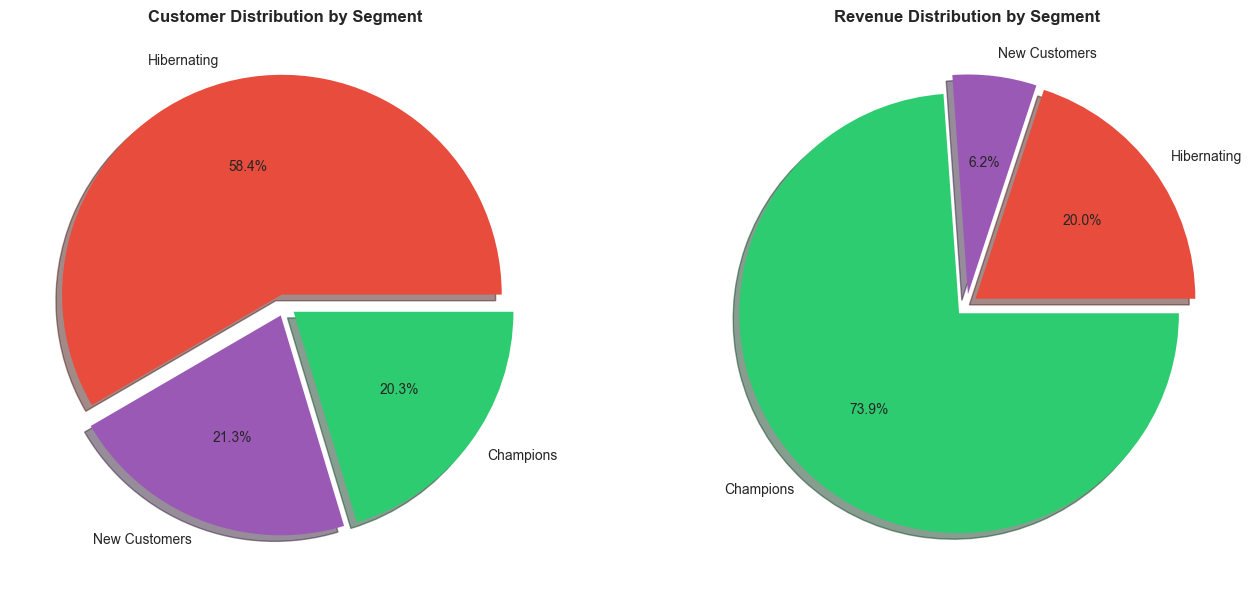


Plot saved: outputs/segmentation/segment_pie_charts.png


In [15]:
# =============================================================================
# CELL 15: SEGMENT VISUALIZATION - PIE AND TREEMAP
# =============================================================================

print("=" * 60)
print("SEGMENT DISTRIBUTION VISUALIZATION")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Customer Distribution (Pie Chart)
ax1 = axes[0]
segment_counts = rfm['Segment'].value_counts()
pie_colors = [colors.get(seg, '#95a5a6') for seg in segment_counts.index]
wedges, texts, autotexts = ax1.pie(
    segment_counts.values, 
    labels=segment_counts.index,
    autopct='%1.1f%%',
    colors=pie_colors,
    explode=[0.05] * len(segment_counts),
    shadow=True
)
ax1.set_title('Customer Distribution by Segment', fontsize=12, fontweight='bold')

# Plot 2: Revenue Distribution (Pie Chart)
ax2 = axes[1]
segment_revenue = rfm.groupby('Segment')['Monetary'].sum()
segment_revenue = segment_revenue.loc[segment_counts.index]  # Match order
pie_colors2 = [colors.get(seg, '#95a5a6') for seg in segment_revenue.index]
wedges2, texts2, autotexts2 = ax2.pie(
    segment_revenue.values,
    labels=segment_revenue.index,
    autopct='%1.1f%%',
    colors=pie_colors2,
    explode=[0.05] * len(segment_revenue),
    shadow=True
)
ax2.set_title('Revenue Distribution by Segment', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/segmentation/segment_pie_charts.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/segmentation/segment_pie_charts.png")

RFM HEATMAP BY SEGMENT


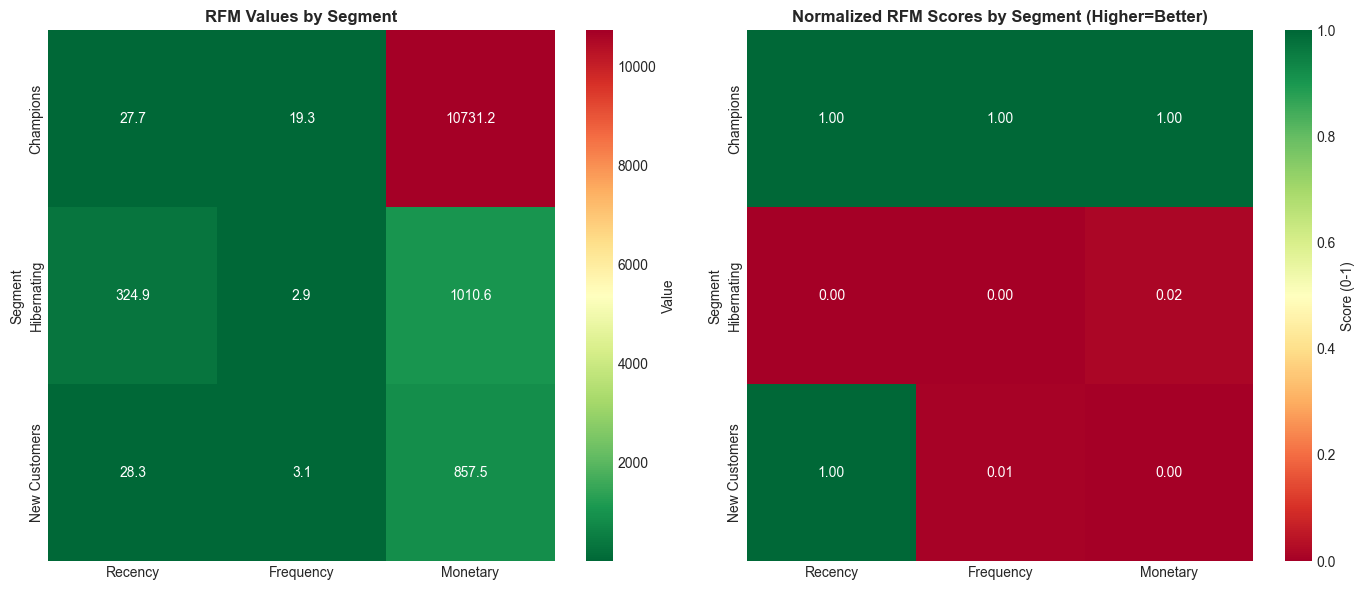


Plot saved: outputs/segmentation/rfm_heatmap.png


In [16]:
# =============================================================================
# CELL 16: RFM HEATMAP
# =============================================================================

print("=" * 60)
print("RFM HEATMAP BY SEGMENT")
print("=" * 60)

# Create normalized RFM for heatmap
segment_rfm = rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean()

# Normalize for heatmap (0-1 scale)
segment_rfm_norm = segment_rfm.copy()
for col in segment_rfm_norm.columns:
    if col == 'Recency':
        # Invert recency (lower is better)
        segment_rfm_norm[col] = 1 - (segment_rfm_norm[col] - segment_rfm_norm[col].min()) / (segment_rfm_norm[col].max() - segment_rfm_norm[col].min())
    else:
        segment_rfm_norm[col] = (segment_rfm_norm[col] - segment_rfm_norm[col].min()) / (segment_rfm_norm[col].max() - segment_rfm_norm[col].min())

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Heatmap 1: Absolute Values
ax1 = axes[0]
sns.heatmap(segment_rfm, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax1, 
            cbar_kws={'label': 'Value'})
ax1.set_title('RFM Values by Segment', fontsize=12, fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('Segment')

# Heatmap 2: Normalized Values
ax2 = axes[1]
sns.heatmap(segment_rfm_norm, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax2,
            cbar_kws={'label': 'Score (0-1)'})
ax2.set_title('Normalized RFM Scores by Segment (Higher=Better)', fontsize=12, fontweight='bold')
ax2.set_xlabel('')
ax2.set_ylabel('Segment')

plt.tight_layout()
plt.savefig('../outputs/segmentation/rfm_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/segmentation/rfm_heatmap.png")

3D CLUSTER VISUALIZATION


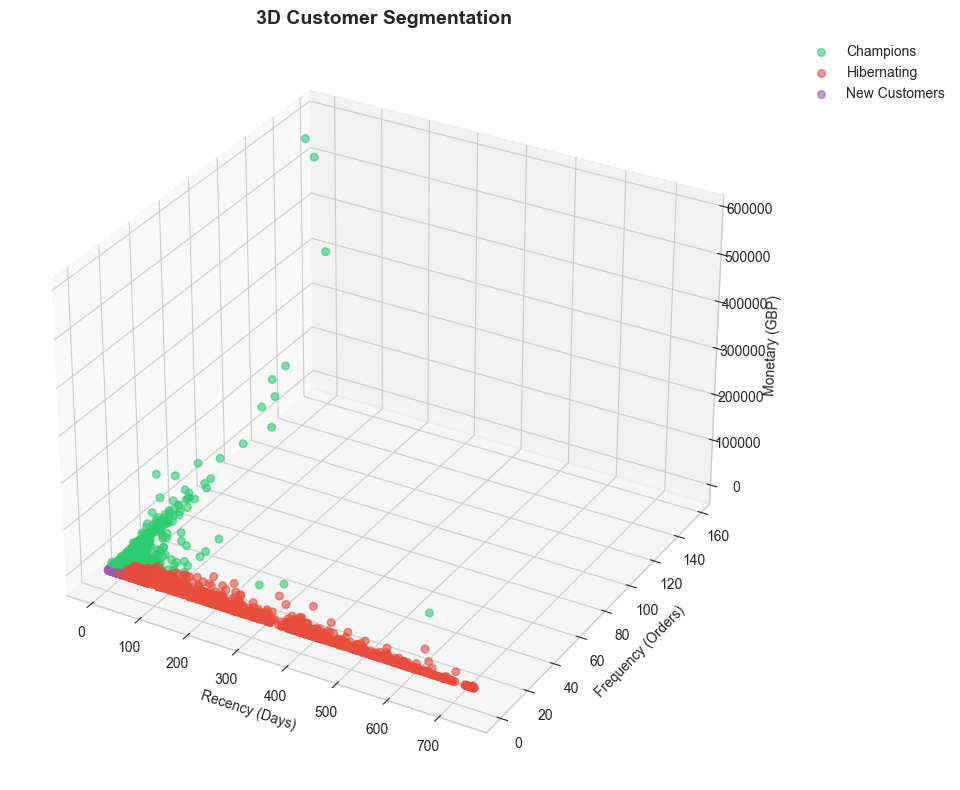


Plot saved: outputs/segmentation/cluster_3d.png


In [17]:
# =============================================================================
# CELL 17: 3D CLUSTER VISUALIZATION
# =============================================================================

print("=" * 60)
print("3D CLUSTER VISUALIZATION")
print("=" * 60)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Sample data for better visualization
sample_size = min(2000, len(rfm))
rfm_sample = rfm.sample(sample_size, random_state=42)

# Create scatter plot
for segment in rfm['Segment'].unique():
    mask = rfm_sample['Segment'] == segment
    ax.scatter(
        rfm_sample.loc[mask, 'Recency'],
        rfm_sample.loc[mask, 'Frequency'],
        rfm_sample.loc[mask, 'Monetary'],
        c=colors.get(segment, '#95a5a6'),
        label=segment,
        alpha=0.6,
        s=30
    )

ax.set_xlabel('Recency (Days)')
ax.set_ylabel('Frequency (Orders)')
ax.set_zlabel('Monetary (GBP)')
ax.set_title('3D Customer Segmentation', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.savefig('../outputs/segmentation/cluster_3d.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/segmentation/cluster_3d.png")

2D CLUSTER VISUALIZATION


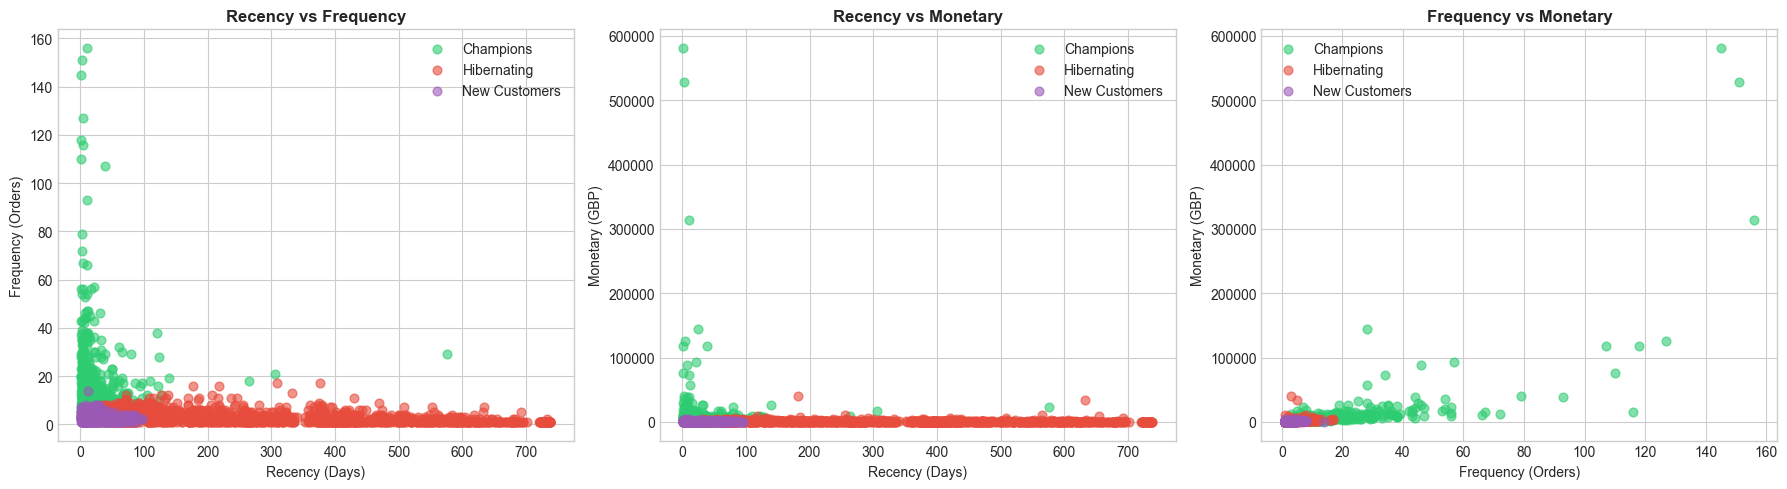


Plot saved: outputs/segmentation/cluster_2d.png


In [18]:
# =============================================================================
# CELL 18: 2D CLUSTER VISUALIZATION
# =============================================================================

print("=" * 60)
print("2D CLUSTER VISUALIZATION")
print("=" * 60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sample_size = min(2000, len(rfm))
rfm_sample = rfm.sample(sample_size, random_state=42)

# Plot 1: Recency vs Frequency
ax1 = axes[0]
for segment in rfm['Segment'].unique():
    mask = rfm_sample['Segment'] == segment
    ax1.scatter(
        rfm_sample.loc[mask, 'Recency'],
        rfm_sample.loc[mask, 'Frequency'],
        c=colors.get(segment, '#95a5a6'),
        label=segment,
        alpha=0.6,
        s=40
    )
ax1.set_xlabel('Recency (Days)')
ax1.set_ylabel('Frequency (Orders)')
ax1.set_title('Recency vs Frequency', fontsize=12, fontweight='bold')
ax1.legend()

# Plot 2: Recency vs Monetary
ax2 = axes[1]
for segment in rfm['Segment'].unique():
    mask = rfm_sample['Segment'] == segment
    ax2.scatter(
        rfm_sample.loc[mask, 'Recency'],
        rfm_sample.loc[mask, 'Monetary'],
        c=colors.get(segment, '#95a5a6'),
        label=segment,
        alpha=0.6,
        s=40
    )
ax2.set_xlabel('Recency (Days)')
ax2.set_ylabel('Monetary (GBP)')
ax2.set_title('Recency vs Monetary', fontsize=12, fontweight='bold')
ax2.legend()

# Plot 3: Frequency vs Monetary
ax3 = axes[2]
for segment in rfm['Segment'].unique():
    mask = rfm_sample['Segment'] == segment
    ax3.scatter(
        rfm_sample.loc[mask, 'Frequency'],
        rfm_sample.loc[mask, 'Monetary'],
        c=colors.get(segment, '#95a5a6'),
        label=segment,
        alpha=0.6,
        s=40
    )
ax3.set_xlabel('Frequency (Orders)')
ax3.set_ylabel('Monetary (GBP)')
ax3.set_title('Frequency vs Monetary', fontsize=12, fontweight='bold')
ax3.legend()

plt.tight_layout()
plt.savefig('../outputs/segmentation/cluster_2d.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/segmentation/cluster_2d.png")

In [19]:
# =============================================================================
# CELL 19: SEGMENT RECOMMENDATIONS
# =============================================================================

print("=" * 60)
print("SEGMENT RECOMMENDATIONS")
print("=" * 60)

# Create recommendations for each segment
recommendations = {
    'Champions': {
        'Description': 'Best customers who bought recently, buy often, and spend the most',
        'Action': 'Reward them with loyalty programs, early access to new products, and VIP treatment',
        'Marketing': 'Exclusive offers, referral programs, premium support'
    },
    'Loyal Customers': {
        'Description': 'Customers who buy regularly and have high engagement',
        'Action': 'Upsell and cross-sell, offer loyalty rewards',
        'Marketing': 'Personalized recommendations, loyalty points, subscription offers'
    },
    'New Customers': {
        'Description': 'Recent first-time buyers with potential for growth',
        'Action': 'Onboard them with welcome offers, educate about products',
        'Marketing': 'Welcome emails, first-purchase discounts, product education'
    },
    'At Risk': {
        'Description': 'Valuable customers who have not purchased recently',
        'Action': 'Re-engage with personalized campaigns before they leave',
        'Marketing': 'Win-back campaigns, special discounts, feedback requests'
    },
    'Hibernating': {
        'Description': 'Low engagement customers who may be lost',
        'Action': 'Attempt reactivation with strong offers, otherwise reduce marketing spend',
        'Marketing': 'Reactivation campaigns, surveys, last-chance offers'
    }
}

for segment, details in recommendations.items():
    count = len(rfm[rfm['Segment'] == segment])
    revenue = rfm[rfm['Segment'] == segment]['Monetary'].sum()
    
    print(f"\n{'='*60}")
    print(f"SEGMENT: {segment.upper()}")
    print(f"{'='*60}")
    print(f"Customers: {count:,}")
    print(f"Total Revenue: {revenue:,.2f} GBP")
    print(f"\nDescription: {details['Description']}")
    print(f"\nRecommended Action: {details['Action']}")
    print(f"\nMarketing Strategy: {details['Marketing']}")

SEGMENT RECOMMENDATIONS

SEGMENT: CHAMPIONS
Customers: 1,196
Total Revenue: 12,834,470.94 GBP

Description: Best customers who bought recently, buy often, and spend the most

Recommended Action: Reward them with loyalty programs, early access to new products, and VIP treatment

Marketing Strategy: Exclusive offers, referral programs, premium support

SEGMENT: LOYAL CUSTOMERS
Customers: 0
Total Revenue: 0.00 GBP

Description: Customers who buy regularly and have high engagement

Recommended Action: Upsell and cross-sell, offer loyalty rewards

Marketing Strategy: Personalized recommendations, loyalty points, subscription offers

SEGMENT: NEW CUSTOMERS
Customers: 1,250
Total Revenue: 1,071,864.29 GBP

Description: Recent first-time buyers with potential for growth

Recommended Action: Onboard them with welcome offers, educate about products

Marketing Strategy: Welcome emails, first-purchase discounts, product education

SEGMENT: AT RISK
Customers: 0
Total Revenue: 0.00 GBP

Description:

In [20]:
# =============================================================================
# CELL 20: SAVE OUTPUTS
# =============================================================================

print("=" * 60)
print("SAVING OUTPUTS")
print("=" * 60)

# 1. Save customer segments
rfm_output = rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Cluster', 'Segment']]
rfm_output.to_csv('../outputs/segmentation/customer_segments.csv', index=False)
print("Saved: outputs/segmentation/customer_segments.csv")

# 2. Save segment summary
segment_summary_full = rfm.groupby('Segment').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum']
}).round(2)
segment_summary_full.columns = ['Customer_Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Total_Revenue']
segment_summary_full['Revenue_Pct'] = (segment_summary_full['Total_Revenue'] / segment_summary_full['Total_Revenue'].sum() * 100).round(2)
segment_summary_full.to_csv('../outputs/segmentation/segment_summary.csv')
print("Saved: outputs/segmentation/segment_summary.csv")

# 3. Save cluster evaluation metrics
cluster_eval.to_csv('../outputs/segmentation/cluster_metrics.csv', index=False)
print("Saved: outputs/segmentation/cluster_metrics.csv")

# 4. Save RFM features for churn prediction (next notebook)
rfm.to_csv('../data/processed/rfm_features.csv', index=False)
print("Saved: data/processed/rfm_features.csv")

# 5. Save for Power BI
rfm_pbi = rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Segment']].copy()
rfm_pbi.to_csv('../outputs/powerbi/segments_for_pbi.csv', index=False)
print("Saved: outputs/powerbi/segments_for_pbi.csv")

segment_summary_full.reset_index().to_csv('../outputs/powerbi/segment_summary_pbi.csv', index=False)
print("Saved: outputs/powerbi/segment_summary_pbi.csv")

print("\nAll segmentation outputs saved successfully")

SAVING OUTPUTS
Saved: outputs/segmentation/customer_segments.csv
Saved: outputs/segmentation/segment_summary.csv
Saved: outputs/segmentation/cluster_metrics.csv
Saved: data/processed/rfm_features.csv
Saved: outputs/powerbi/segments_for_pbi.csv
Saved: outputs/powerbi/segment_summary_pbi.csv

All segmentation outputs saved successfully


In [21]:
# =============================================================================
# CELL 21: SUMMARY REPORT
# =============================================================================

print("=" * 70)
print("NOTEBOOK 04 - CUSTOMER SEGMENTATION SUMMARY REPORT")
print("=" * 70)

report = f"""
-----------------------------------------------------------------------------
                     CUSTOMER SEGMENTATION SUMMARY
-----------------------------------------------------------------------------

DATA OVERVIEW
-----------------------------------------
Total Customers:         {len(rfm):,}
Reference Date:          {reference_date.date()}

RFM METRICS SUMMARY
-----------------------------------------
                  Recency    Frequency    Monetary
Mean              {rfm['Recency'].mean():>8.1f}    {rfm['Frequency'].mean():>9.2f}    {rfm['Monetary'].mean():>10,.2f}
Median            {rfm['Recency'].median():>8.1f}    {rfm['Frequency'].median():>9.0f}    {rfm['Monetary'].median():>10,.2f}

CLUSTERING MODEL
-----------------------------------------
Algorithm:               K-Means
Number of Clusters:      {optimal_k}
Silhouette Score:        {silhouette_score(X_scaled, cluster_labels):.4f}

SEGMENT DISTRIBUTION
-----------------------------------------
"""

for segment in segment_summary_full.index:
    count = segment_summary_full.loc[segment, 'Customer_Count']
    pct = count / len(rfm) * 100
    rev = segment_summary_full.loc[segment, 'Total_Revenue']
    rev_pct = segment_summary_full.loc[segment, 'Revenue_Pct']
    report += f"{segment:20} {count:>6,} ({pct:>5.1f}%)  Revenue: {rev:>12,.0f} ({rev_pct:>5.1f}%)\n"

report += f"""
FILES GENERATED
-----------------------------------------
Models:
  - kmeans_model.pkl
  - scaler.pkl

Outputs:
  - rfm_distributions.png
  - log_transformation.png
  - cluster_evaluation.png
  - segment_bar_charts.png
  - segment_pie_charts.png
  - rfm_heatmap.png
  - cluster_3d.png
  - cluster_2d.png

CSV Files:
  - customer_segments.csv
  - segment_summary.csv
  - cluster_metrics.csv
  - rfm_features.csv
  - segments_for_pbi.csv
  - segment_summary_pbi.csv

-----------------------------------------------------------------------------
READY FOR NOTEBOOK 05: CHURN PREDICTION
-----------------------------------------------------------------------------
"""

print(report)

NOTEBOOK 04 - CUSTOMER SEGMENTATION SUMMARY REPORT

-----------------------------------------------------------------------------
                     CUSTOMER SEGMENTATION SUMMARY
-----------------------------------------------------------------------------

DATA OVERVIEW
-----------------------------------------
Total Customers:         5,878
Reference Date:          2011-12-10

RFM METRICS SUMMARY
-----------------------------------------
                  Recency    Frequency    Monetary
Mean                 201.3         6.29      2,955.90
Median                96.0            3        867.74

CLUSTERING MODEL
-----------------------------------------
Algorithm:               K-Means
Number of Clusters:      4
Silhouette Score:        0.3650

SEGMENT DISTRIBUTION
-----------------------------------------
Champions             1,196 ( 20.3%)  Revenue:   12,834,471 ( 73.9%)
Hibernating           3,432 ( 58.4%)  Revenue:    3,468,469 ( 20.0%)
New Customers         1,250 ( 21.3%)  Rev